In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from math import sqrt
from keras.callbacks import History 
import gc
from numpy.random import randint, choice

import keras.backend as K

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

In [3]:
input_dim = (45,45,3)

basePath = "/home/rsk/Documents/Projects/GenericModels/SiameseNetworks/Dataset"
trainPath = os.path.join(basePath,'Train')
testPath = os.path.join(basePath,'Test')

#### Superlist method 1

In [4]:
superList = []

os.chdir(trainPath)

folderList = os.listdir("./")

for folder in folderList:
    os.chdir(os.path.join(trainPath,folder))
    
    
    imgList = os.listdir("./")
    
    #Appending positive samples
    for i in range(14):
        img1 = read_img(os.path.join(trainPath,folder,imgList[i]), (45,45))
        img2 = read_img(os.path.join(trainPath,folder,imgList[i+1]), (45,45))
        
        superList.append(((img1,img2),1))
        
    img1 = read_img(os.path.join(trainPath,folder,imgList[14]), (45,45))
    img2 = read_img(os.path.join(trainPath,folder,imgList[0]), (45,45))
    
    superList.append(((img1,img2),1))
    
    #Appending negative samples
    
    for i in range(14):
        
        altFolder = choice(folderList)
        while(altFolder==folder):
            altFolder = choice(folderList)
            
        altImage = choice(os.listdir(os.path.join(trainPath,altFolder)))
            
        img1 = read_img(os.path.join(trainPath,folder,imgList[i]), (45,45))
        img2 = read_img(os.path.join(trainPath,altFolder,altImage), (45,45))
        
        superList.append(((img1,img2),0))
        
    

In [5]:
np.random.shuffle(superList)

#### Superlist method2

In [93]:
superList = []

folderList = os.listdir(trainPath)
numPairs = 1400


In [94]:
# Adding positive samples

for i in range(numPairs):
    
    folder = choice(folderList)
    
    imgList = choice( os.listdir(os.path.join(trainPath,folder)), 2, replace = False ) 
    
    img1 = read_img(os.path.join(trainPath,folder,imgList[0]), (45,45))
    img2 = read_img(os.path.join(trainPath,folder,imgList[1]), (45,45))
    
    superList.append(((img1,img2),1))
    
    

In [95]:
# Adding negative samples
for i in range(numPairs):
    
    folders = choice(folderList, 2, replace = False)
    
    imgList1 = choice( os.listdir(os.path.join(trainPath,folders[0]))) 
    imgList2 = choice( os.listdir(os.path.join(trainPath,folders[1]))) 
    
    img1 = read_img(os.path.join(trainPath,folders[0],imgList1), (45,45))
    img2 = read_img(os.path.join(trainPath,folders[1],imgList2), (45,45))
    
    superList.append(((img1,img2),0))

1


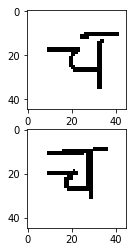

In [96]:
i=34

i = choice(list(range(len(superList))))

plt.subplot(211)
plt.imshow(superList[i][0][0])
    
plt.subplot(212)
plt.imshow(superList[i][0][1])

print(superList[i][1])

In [7]:
baseModel = Sequential()
baseModel.add(BatchNormalization(input_shape = input_dim))
baseModel.add(Conv2D(64, (3,3),activation='relu', data_format='channels_last'))

baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(32, (3,3),activation='relu'))
baseModel.add(Flatten())
baseModel.add(Dense(256, activation='relu'))
baseModel.add(Dense(32, activation='relu'))


In [8]:
inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)

In [9]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([outputA, outputB])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[inputA,inputB],outputs=prediction)

siamese_net.compile(loss="binary_crossentropy",optimizer='adadelta',metrics=['accuracy'])

In [10]:
#Extracting data
inputAimgs = np.array([x[0][0] for x in superList])
inputBimgs = np.array([x[0][1] for x in superList])
target = np.array([x[1] for x in superList])

In [27]:
siamese_net.fit([inputAimgs,inputBimgs], target, batch_size = 20,epochs = 10 )

Epoch 1/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0578 - acc: 0.9782
Epoch 2/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0386 - acc: 0.9874
Epoch 3/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0122 - acc: 0.9966
Epoch 4/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0142 - acc: 0.9966
Epoch 5/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0025 - acc: 1.0000
Epoch 6/10
870/870 [==============================] - 3s 3ms/step - loss: 0.0026 - acc: 0.9989
Epoch 7/10
870/870 [==============================] - 3s 3ms/step - loss: 9.2482e-04 - acc: 1.0000
Epoch 8/10
870/870 [==============================] - 3s 3ms/step - loss: 3.7850e-04 - acc: 1.0000
Epoch 9/10
870/870 [==============================] - 3s 3ms/step - loss: 1.8870e-04 - acc: 1.0000
Epoch 10/10
870/870 [==============================] - 3s 3ms/step - loss: 1.3985e-04 - acc: 1.0000


#### Testing

In [28]:
os.chdir(testPath)
folderList = os.listdir("./")

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(testPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        
        testImageCount+=1
        supportImg = getSupportImgs(trainPath)
        
        img = read_img(os.path.join(testPath,folder,img), (45,45))
        bestLabel = predictBest(img,folder,supportImg,siamese_net)
        
        if bestLabel == folder:
            correctPred+=1
        print("Img : {} True Label : {}  Predicted Label : {}".format(img,folder,bestLabel))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

True Label : character21  Predicted Label : character06
True Label : character21  Predicted Label : character21
True Label : character21  Predicted Label : character03
True Label : character21  Predicted Label : character12
True Label : character21  Predicted Label : character19
True Label : character23  Predicted Label : character12
True Label : character23  Predicted Label : character14
True Label : character23  Predicted Label : character06
True Label : character23  Predicted Label : character29
True Label : character23  Predicted Label : character25
True Label : character06  Predicted Label : character06
True Label : character06  Predicted Label : character17
True Label : character06  Predicted Label : character04
True Label : character06  Predicted Label : character30
True Label : character06  Predicted Label : character28
True Label : character14  Predicted Label : character17
True Label : character14  Predicted Label : character14
True Label : character14  Predicted Label : char

True Label : character05  Predicted Label : character07
True Label : character05  Predicted Label : character29
True Label : character05  Predicted Label : character26


IndexError: tuple index out of range

In [29]:
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Accuracy : 0.106666666667


In [20]:
def getSupportImgs(path):
    
    supportImg=[]
    
    os.chdir(path)
    folderList = os.listdir("./")
    
    for folder in folderList:
        os.chdir(os.path.join(path,folder))
        imgList = os.listdir("./")
        
        img = read_img(os.path.join(path,folder,choice(imgList)), (45,45))
        supportImg.append([img,folder])
        
    return(supportImg)
        

In [14]:
supportImg = getSupportImgs(trainPath)

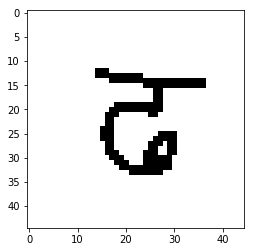

In [18]:
plt.imshow(supportImg[3])

In [34]:
def predictBest(img,label,imgS,model):
    
    bestPred=0.0
    bestLabel=''
    bestImg = 0
    
    plt.subplot(211)
    plt.imshow(img)
    
    for i in range(len(imgSupport)):
        pred = model.predict([img.reshape(1,45,45,3), imgSupport[i][0].reshape(1,45,45,3)])
        print("label : {}  Pred : {}".format(imgSupport[i][1], pred))
        
        if pred>bestPred:
            bestPred = pred
            bestLabel = imgSupport[i][1]
            bestImg = imgSupport[i][0]
    
    plt.subplot(212)
    plt.imshow(bestImg)
    return(bestLabel)
    
    
    

In [16]:
siamese_net.predict([a.reshape(1,45,45,3), a.reshape(1,45,45,3)])

array([[0.503601]], dtype=float32)

In [78]:
a=read_img('/home/rsk/Documents/Projects/GenericModels/SiameseNetworks/Dataset/Test/character01/0851_16.png',(45,45))


label : character21  Pred : [[0.45111015]]
label : character23  Pred : [[1.]]
label : character06  Pred : [[0.99287474]]
label : character14  Pred : [[0.21940349]]
label : character08  Pred : [[0.9975338]]
label : character03  Pred : [[0.75633377]]
label : character28  Pred : [[0.03379844]]
label : character04  Pred : [[0.05747412]]
label : character12  Pred : [[0.00017568]]
label : character25  Pred : [[1.]]
label : character26  Pred : [[0.9990927]]
label : character22  Pred : [[0.00094422]]
label : character13  Pred : [[0.99997115]]
label : character16  Pred : [[0.9732457]]
label : character27  Pred : [[2.1100657e-08]]
label : character15  Pred : [[0.00029584]]
label : character20  Pred : [[0.08792388]]
label : character18  Pred : [[3.280949e-06]]
label : character17  Pred : [[0.00689163]]
label : character24  Pred : [[0.7617762]]
label : character07  Pred : [[4.7738905e-07]]
label : character10  Pred : [[0.95226467]]
label : character11  Pred : [[1.5242441e-05]]
label : character01 

'character23'

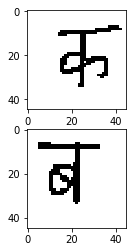

In [35]:
predictBest(a,'asd',getSupportImgs(trainPath),siamese_net)

In [86]:
def predictBestFolder(img,label,trainPath,model,numImages = 5,printList = False):
    
    predList = []
    
    folderList = sorted(os.listdir(trainPath))
    
    for folder in folderList:
        
        imgList = choice(os.listdir(os.path.join(trainPath,folder)), numImages, replace = False )
        folderPreds = []
        
        for i in range(numImages):
            folderImg = read_img(os.path.join(trainPath,folder,imgList[i]), (45,45) )
            pred = model.predict([img.reshape(1,45,45,3), folderImg.reshape(1,45,45,3)])
            folderPreds.append(pred)
        
        predList.append([folder, np.mean(folderPreds)])
    
    predList = sorted(predList, key = lambda x:-x[1])
    
    if printList == True:
        print(predList)
        
    return(predList[0])
        

In [88]:
predictBestFolder(a,'asdas',trainPath,siamese_net,15,printList=True)

[['character03', 0.8465592], ['character04', 0.8427508], ['character23', 0.7834415], ['character25', 0.7774849], ['character26', 0.745342], ['character30', 0.6653631], ['character17', 0.63764393], ['character08', 0.59750974], ['character10', 0.5668778], ['character06', 0.5546636], ['character01', 0.4859684], ['character29', 0.48585892], ['character15', 0.4635396], ['character07', 0.45810488], ['character28', 0.44521216], ['character24', 0.43482208], ['character21', 0.41965958], ['character16', 0.34541532], ['character19', 0.3234937], ['character09', 0.2905371], ['character20', 0.2670595], ['character12', 0.24275292], ['character02', 0.23775712], ['character22', 0.20412439], ['character05', 0.18531868], ['character13', 0.081375], ['character18', 0.054295145], ['character14', 0.01563599], ['character27', 2.6362954e-05], ['character11', 1.2893236e-06]]


['character03', 0.8465592]